# Import

In [1]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
from transformers import DataCollatorWithPadding
import optuna
from huggingface_hub import notebook_login

# Datasets

In [3]:
# lables value

# 2 = positive
# 1 = neutral
# 0 = negative

In [4]:
dataset_tweet= load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
dataset_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 870
    })
})

In [5]:
dataset_tweet_cc = concatenate_datasets([dataset_tweet['train'], dataset_tweet['validation'],dataset_tweet['test']])
dataset_tweet_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 3033
})

In [6]:
dataset_mteb = load_dataset("mteb/tweet_sentiment_extraction")

In [7]:
dataset_mteb

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [8]:
dataset_mteb_cc = concatenate_datasets([dataset_mteb['train'], dataset_mteb['test']])
dataset_mteb_cc

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 31015
})

In [9]:
dataset_mteb_cc=dataset_mteb_cc.remove_columns('label_text')
dataset_mteb_cc=dataset_mteb_cc.remove_columns('id')

dataset_mteb_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 31015
})

In [10]:
dataset_tweet_cc.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [11]:
dataset_mteb_cc.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [12]:
features = dataset_mteb_cc.features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [dataset_mteb_cc for dataset_mteb_cc in batch["label"]]
    return batch
label_dataset = dataset_mteb_cc.map(adjust_labels, batched=True, features=features)

In [13]:
label_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [14]:
dataset_cc = concatenate_datasets([label_dataset, dataset_tweet_cc])
dataset_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 34048
})

## test dataset

In [15]:
notebook_login()

In [16]:
raw_dataset=load_dataset("HFFErica/sentimentanalysis")
print(raw_dataset)

DatasetDict({
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1700
    })
})


In [17]:
features = raw_dataset["test"].features.copy()
features["labels_three_2p"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["labels_three_2p"] = [test for test in batch["labels_three_2p"]]
    return batch
label_dataset = raw_dataset.map(adjust_labels, batched=True, features=features)

In [18]:
label_dataset["test"].features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [19]:
label_dataset_split = label_dataset['test'].train_test_split(test_size=0.4112, stratify_by_column="labels_three_2p")
label_dataset_split

DatasetDict({
    train: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 700
    })
})

### test dataset groups

In [20]:
test_dataset=label_dataset_split['train']
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})

In [21]:
pretrain_test_dataset=label_dataset_split['test']
pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})

In [22]:
test_dataset.features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

### Pretrain merge

In [23]:
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_five')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_three')

pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels_three_2p'],
    num_rows: 700
})

In [24]:
pretrain_test_dataset=pretrain_test_dataset.rename_column("sequence", "text")
pretrain_test_dataset=pretrain_test_dataset.rename_column("labels_three_2p", "label")

pretrain_test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 700
})

In [25]:
dataset_ccc = concatenate_datasets([dataset_cc,pretrain_test_dataset])
dataset_ccc

Dataset({
    features: ['text', 'label'],
    num_rows: 34748
})

## split 

In [26]:
ds = dataset_ccc.train_test_split(test_size=0.2, stratify_by_column="label")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27798
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6950
    })
})

In [27]:
train_dataset = ds['train']
validation_dataset = ds['test']
print(train_dataset)
print(validation_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27798
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6950
})


## label balance

<Axes: ylabel='count'>

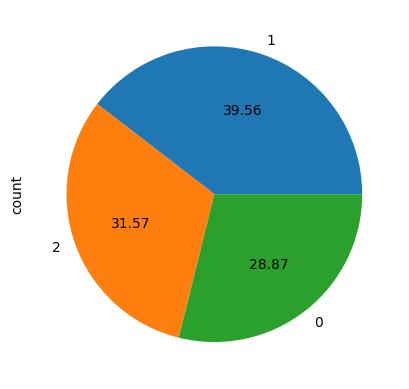

In [28]:
df_train = train_dataset.to_pandas()
df_train.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

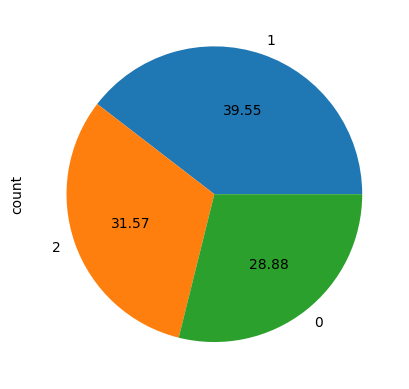

In [29]:
df_validation = validation_dataset.to_pandas()
df_validation.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

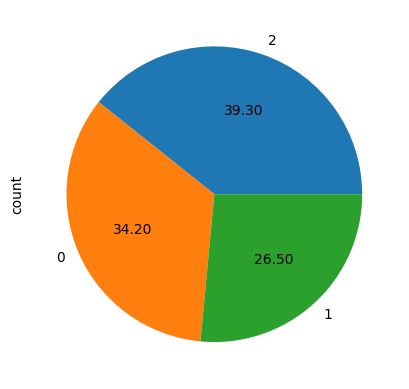

In [30]:
df_test = test_dataset.to_pandas()
df_test.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

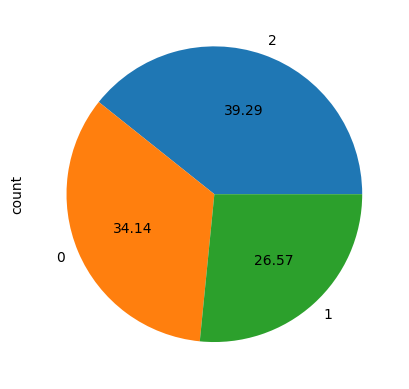

In [31]:
df_pretest = pretrain_test_dataset.to_pandas()
df_pretest.label.value_counts().plot(kind = 'pie', autopct="%.2f")

## Map

In [32]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)
print(pretrain_test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27798
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6950
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 700
})


In [33]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['labels_three_2p']}, batched=True)

Map:   0%|          | 0/27798 [00:00<?, ? examples/s]

Map:   0%|          | 0/6950 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Model 

In [34]:
model_id="cardiffnlp/twitter-roberta-base-sentiment-latest"



# label2id = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                           num_labels=train_dataset.features["label"].num_classes,
#                                                            id2label=label2id,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment-latest",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [35]:
MAX_LENGTH = 256
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['sequence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Map:   0%|          | 0/27798 [00:00<?, ? examples/s]

Map:   0%|          | 0/6950 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [36]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [37]:
# train_dataset.set_format(type='torch', columns=['input_ids','token_type_ids', 'attention_mask', 'labels'])
# validation_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [38]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameter search

In [39]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [40]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset, 
    eval_dataset=validation_dataset, 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed",41, 42),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 24, 32, 36, 40, 48,56, 64,72]),
    }

In [42]:
trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2023-12-13 10:41:52,772] A new study created in memory with name: no-name-9951e146-9d51-4025-86cd-516a8e32ade8
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.535, 'learning_rate': 5.340267686962789e-06, 'epoch': 1.15}
{'eval_loss': 0.532142162322998, 'eval_accuracy': 0.7866187050359712, 'eval_f1': 0.7903816320977451, 'eval_precision': 0.7893049192256839, 'eval_recall': 0.7952234290654925, 'eval_runtime': 320.1706, 'eval_samples_per_second': 21.707, 'eval_steps_per_second': 2.714, 'epoch': 1.15}
{'loss': 0.4722, 'learning_rate': 3.186933942219729e-06, 'epoch': 2.3}
{'eval_loss': 0.5099084973335266, 'eval_accuracy': 0.7943884892086331, 'eval_f1': 0.7980736357420555, 'eval_precision': 0.8004130579880849, 'eval_recall': 0.7961558261556237, 'eval_runtime': 320.5915, 'eval_samples_per_second': 21.679, 'eval_steps_per_second': 2.711, 'epoch': 2.3}
{'loss': 0.4303, 'learning_rate': 1.0336001974766688e-06, 'epoch': 3.45}
{'eval_loss': 0.5238240361213684, 'eval_accuracy': 0.7910791366906474, 'eval_f1': 0.7945007198768025, 'eval_precision': 0.793099440507699, 'eval_recall': 0.7961298638769012, 'eval_runtime': 320.7622, 'eval_samples_per_sec

[I 2023-12-13 17:46:53,300] Trial 0 finished with value: 3.17480916095205 and parameters: {'learning_rate': 7.493601431705849e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 3.17480916095205.


{'train_runtime': 25479.3589, 'train_samples_per_second': 4.364, 'train_steps_per_second': 0.068, 'train_loss': 0.46993981284656744, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁█▅
eval/f1,▁█▅
eval/loss,█▁▅
eval/precision,▁█▃
eval/recall,▁██
eval/runtime,▁▆█
eval/samples_per_second,█▃▁
eval/steps_per_second,█▄▁
train/epoch,▁▁▄▄▇▇█
train/global_step,▁▁▄▄▇▇█
train/learning_rate,█▅▁


{'loss': 0.6369, 'learning_rate': 7.81420097078426e-05, 'epoch': 0.58}
{'eval_loss': 0.5744443535804749, 'eval_accuracy': 0.7607194244604316, 'eval_f1': 0.7609544111316947, 'eval_precision': 0.7999636174854672, 'eval_recall': 0.7484486449297497, 'eval_runtime': 40.5548, 'eval_samples_per_second': 171.373, 'eval_steps_per_second': 21.428, 'epoch': 0.58}
{'loss': 0.525, 'learning_rate': 4.658223195831005e-05, 'epoch': 1.15}
{'eval_loss': 0.5910080075263977, 'eval_accuracy': 0.781726618705036, 'eval_f1': 0.7859171772423599, 'eval_precision': 0.7939593371326555, 'eval_recall': 0.7818209883570247, 'eval_runtime': 40.4966, 'eval_samples_per_second': 171.619, 'eval_steps_per_second': 21.459, 'epoch': 1.15}
{'loss': 0.3966, 'learning_rate': 1.5022454208777494e-05, 'epoch': 1.73}
{'eval_loss': 0.5476845502853394, 'eval_accuracy': 0.7858992805755396, 'eval_f1': 0.7899133938045414, 'eval_precision': 0.7904870511312447, 'eval_recall': 0.7902616218915283, 'eval_runtime': 40.4737, 'eval_samples_per_

[I 2023-12-13 18:05:11,152] Trial 1 finished with value: 3.156561347402854 and parameters: {'learning_rate': 0.00010970178745737516, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 3.17480916095205.


{'train_runtime': 1095.251, 'train_samples_per_second': 50.761, 'train_steps_per_second': 1.587, 'train_loss': 0.5000032308598246, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,▅█▁
eval/precision,█▄▁
eval/recall,▁▇█
eval/runtime,█▃▁
eval/samples_per_second,▁▆█
eval/steps_per_second,▁▆█
train/epoch,▁▁▄▄▇▇█
train/global_step,▁▁▄▄▇▇█
train/learning_rate,█▄▁


{'train_runtime': 5423.9754, 'train_samples_per_second': 5.125, 'train_steps_per_second': 0.092, 'train_loss': 1.1041957310267858, 'epoch': 1.0}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-13 19:36:17,110] Trial 2 finished with value: 1.0496736121773784 and parameters: {'learning_rate': 0.0008443084419650327, 'num_train_epochs': 1, 'per_device_train_batch_size': 56}. Best is trial 0 with value: 3.17480916095205.


{'eval_loss': 1.0898996591567993, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 39.8028, 'eval_samples_per_second': 174.611, 'eval_steps_per_second': 21.833, 'epoch': 1.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'loss': 0.5967, 'learning_rate': 3.03124084446206e-05, 'epoch': 0.29}
{'eval_loss': 0.5680664777755737, 'eval_accuracy': 0.7703597122302158, 'eval_f1': 0.7745446122367557, 'eval_precision': 0.78010622324134, 'eval_recall': 0.7777203233621117, 'eval_runtime': 40.4131, 'eval_samples_per_second': 171.974, 'eval_steps_per_second': 21.503, 'epoch': 0.29}
{'loss': 0.5618, 'learning_rate': 2.846183405850213e-05, 'epoch': 0.58}
{'eval_loss': 0.5632843971252441, 'eval_accuracy': 0.7779856115107914, 'eval_f1': 0.7775974686788366, 'eval_precision': 0.8043553107431959, 'eval_recall': 0.769695560120024, 'eval_runtime': 40.4019, 'eval_samples_per_second': 172.021, 'eval_steps_per_second': 21.509, 'epoch': 0.58}
{'loss': 0.5444, 'learning_rate': 2.6611259672383652e-05, 'epoch': 0.86}
{'eval_loss': 0.522808313369751, 'eval_accuracy': 0.781726618705036, 'eval_f1': 0.784746665168305, 'eval_precision': 0.7987708122322612, 'eval_recall': 0.7772178225345239, 'eval_runtime': 40.4857, 'eval_samples_per_seco

[I 2023-12-13 20:35:08,434] Trial 3 finished with value: 3.120273254113511 and parameters: {'learning_rate': 3.216298283073908e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 3.17480916095205.


{'train_runtime': 3528.8984, 'train_samples_per_second': 39.386, 'train_steps_per_second': 2.463, 'train_loss': 0.30870146866634884, 'epoch': 5.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▂▄▅▁▃▆█▅▆▄▆▆▆▇▅▅▄
eval/f1,▃▄▆▁▃▇█▆▇▄▆▆▆▇▅▅▅
eval/loss,▁▁▁▂▂▂▂▄▃▃▆▆▆▆███
eval/precision,▃█▇▁▂▄▅▄▅▂▄▄▅▅▃▄▃
eval/recall,▃▁▃▅▃▇█▅▆▅▆▆▅▆▅▄▄
eval/runtime,▁▁▄▄▄▅▄▄▅▄▄▅▆▆▆██
eval/samples_per_second,██▅▅▅▄▅▅▄▅▅▄▃▃▃▁▁
eval/steps_per_second,██▅▅▅▄▅▅▄▅▄▄▃▃▃▁▁
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,██▇▇▆▆▅▅▅▄▄▃▃▂▂▁▁


{'loss': 1.1075, 'learning_rate': 0.00022792624081104156, 'epoch': 0.65}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0932167768478394, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 40.1358, 'eval_samples_per_second': 173.162, 'eval_steps_per_second': 21.651, 'epoch': 0.65}


[I 2023-12-13 21:00:04,429] Trial 4 finished with value: 1.0496736121773784 and parameters: {'learning_rate': 0.0006453735683037917, 'num_train_epochs': 1, 'per_device_train_batch_size': 36}. Best is trial 0 with value: 3.17480916095205.


{'train_runtime': 1492.8926, 'train_samples_per_second': 18.62, 'train_steps_per_second': 0.518, 'train_loss': 1.1020778641201083, 'epoch': 1.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 0.561, 'learning_rate': 4.7655406723061104e-05, 'epoch': 0.86}
{'eval_loss': 0.5353406667709351, 'eval_accuracy': 0.7823021582733813, 'eval_f1': 0.786677458234715, 'eval_precision': 0.7950366745047722, 'eval_recall': 0.7816807801503379, 'eval_runtime': 39.9649, 'eval_samples_per_second': 173.903, 'eval_steps_per_second': 21.744, 'epoch': 0.86}
{'loss': 0.4229, 'learning_rate': 3.772719698909004e-05, 'epoch': 1.72}
{'eval_loss': 0.5380491018295288, 'eval_accuracy': 0.7867625899280576, 'eval_f1': 0.7903427253128384, 'eval_precision': 0.7885260316653571, 'eval_recall': 0.7944811370642304, 'eval_runtime': 39.9703, 'eval_samples_per_second': 173.879, 'eval_steps_per_second': 21.741, 'epoch': 1.72}
{'loss': 0.2947, 'learning_rate': 2.779898725511898e-05, 'epoch': 2.59}
{'eval_loss': 0.6656523942947388, 'eval_accuracy': 0.7834532374100719, 'eval_f1': 0.787639345116436, 'eval_precision': 0.7880424165118444, 'eval_recall': 0.7878392714550763, 'eval_runtime': 39.9981, 'eval_samples_per_

[I 2023-12-14 02:43:46,649] Trial 5 finished with value: 3.1319959310740866 and parameters: {'learning_rate': 5.758361645703217e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 48}. Best is trial 0 with value: 3.17480916095205.


{'train_runtime': 20619.9787, 'train_samples_per_second': 6.741, 'train_steps_per_second': 0.141, 'train_loss': 0.28669978569293847, 'epoch': 5.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▃█▅▁▁
eval/f1,▄█▅▁▂
eval/loss,▁▁▃▅█
eval/precision,█▅▄▁▁
eval/recall,▁█▄▄▄
eval/runtime,▁▁▂▅█
eval/samples_per_second,██▆▄▁
eval/steps_per_second,██▇▄▁
train/epoch,▁▁▂▂▄▄▅▅▇▇█
train/global_step,▁▁▂▂▄▄▅▅▇▇█
train/learning_rate,█▆▅▃▁


{'loss': 1.1007, 'learning_rate': 0.00028848220599595695, 'epoch': 1.01}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-14 04:19:41,898] Trial 6 pruned. 


{'eval_loss': 1.0969150066375732, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 40.0353, 'eval_samples_per_second': 173.597, 'eval_steps_per_second': 21.706, 'epoch': 1.01}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.5673, 'learning_rate': 4.014740273142484e-06, 'epoch': 0.58}
{'eval_loss': 0.5160720348358154, 'eval_accuracy': 0.7874820143884892, 'eval_f1': 0.7911444514128313, 'eval_precision': 0.7945230687988896, 'eval_recall': 0.7884621496743772, 'eval_runtime': 41.1856, 'eval_samples_per_second': 168.748, 'eval_steps_per_second': 21.1, 'epoch': 0.58}
{'loss': 0.5096, 'learning_rate': 3.4926674157767513e-06, 'epoch': 1.15}
{'eval_loss': 0.5188100934028625, 'eval_accuracy': 0.7887769784172662, 'eval_f1': 0.7922587725152566, 'eval_precision': 0.7909835858123738, 'eval_recall': 0.7937438209550421, 'eval_runtime': 41.18, 'eval_samples_per_second': 168.771, 'eval_steps_per_second': 21.102, 'epoch': 1.15}
{'loss': 0.4853, 'learning_rate': 2.970594558411019e-06, 'epoch': 1.73}
{'eval_loss': 0.5201698541641235, 'eval_accuracy': 0.7916546762589928, 'eval_f1': 0.7955980226667229, 'eval_precision': 0.7950282916848922, 'eval_recall': 0.7977025421552414, 'eval_runtime': 41.182, 'eval_samples_per_se

[I 2023-12-14 05:06:15,007] Trial 7 finished with value: 3.184606903287314 and parameters: {'learning_rate': 4.536813130508217e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 32}. Best is trial 7 with value: 3.184606903287314.


{'train_runtime': 2790.5236, 'train_samples_per_second': 49.808, 'train_steps_per_second': 1.557, 'train_loss': 0.46228589934775965, 'epoch': 5.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁▂▅█▆▅▆▇
eval/f1,▁▂▅█▆▅▅▇
eval/loss,▄▄▅▁▃█▆▆
eval/precision,▄▁▅█▆▃▄▅
eval/recall,▁▅▇█▆█▇█
eval/runtime,▂▁▁▄█▄▄▄
eval/samples_per_second,▇██▅▁▅▅▅
eval/steps_per_second,███▅▁▅▅▅
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▆▆▇▇█
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▆▆▇▇█
train/learning_rate,█▇▆▅▄▃▂▁


{'loss': 1.1076, 'learning_rate': 0.0003986794885811867, 'epoch': 0.72}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-14 05:40:28,070] Trial 8 pruned. 


{'eval_loss': 1.090027928352356, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 40.2179, 'eval_samples_per_second': 172.808, 'eval_steps_per_second': 21.607, 'epoch': 0.72}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 1.1005, 'learning_rate': 0.00022144520138449528, 'epoch': 1.29}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-14 08:25:12,355] Trial 9 pruned. 


{'eval_loss': 1.0930365324020386, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 311.3935, 'eval_samples_per_second': 22.319, 'eval_steps_per_second': 2.791, 'epoch': 1.29}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.5976, 'learning_rate': 1.1922306199532208e-06, 'epoch': 0.43}


[I 2023-12-14 08:29:24,087] Trial 10 pruned. 


{'eval_loss': 0.5476834177970886, 'eval_accuracy': 0.7669064748201438, 'eval_f1': 0.7704209356066757, 'eval_precision': 0.768209129091832, 'eval_recall': 0.7733687053415542, 'eval_runtime': 41.2709, 'eval_samples_per_second': 168.399, 'eval_steps_per_second': 21.056, 'epoch': 0.43}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.5366, 'learning_rate': 4.945773677970598e-06, 'epoch': 1.15}
{'eval_loss': 0.5298112034797668, 'eval_accuracy': 0.7871942446043165, 'eval_f1': 0.7908698102623073, 'eval_precision': 0.7894222451661466, 'eval_recall': 0.7957627293324755, 'eval_runtime': 315.551, 'eval_samples_per_second': 22.025, 'eval_steps_per_second': 2.754, 'epoch': 1.15}
{'loss': 0.4759, 'learning_rate': 2.951510098143744e-06, 'epoch': 2.3}
{'eval_loss': 0.5087027549743652, 'eval_accuracy': 0.7935251798561151, 'eval_f1': 0.7972585639835866, 'eval_precision': 0.7993354333009552, 'eval_recall': 0.795548620466663, 'eval_runtime': 336.2373, 'eval_samples_per_second': 20.67, 'eval_steps_per_second': 2.584, 'epoch': 2.3}
{'loss': 0.4362, 'learning_rate': 9.5724651831689e-07, 'epoch': 3.45}
{'eval_loss': 0.5224943161010742, 'eval_accuracy': 0.7920863309352518, 'eval_f1': 0.7955065379944651, 'eval_precision': 0.7940205461180166, 'eval_recall': 0.7972476322985566, 'eval_runtime': 338.1658, 'eval_samples_per_second

[I 2023-12-14 16:18:48,999] Trial 11 finished with value: 3.1788610473462904 and parameters: {'learning_rate': 6.940037257797452e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 64}. Best is trial 7 with value: 3.184606903287314.


{'train_runtime': 28162.7021, 'train_samples_per_second': 3.948, 'train_steps_per_second': 0.062, 'train_loss': 0.4740969910018745, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁█▆
eval/f1,▁█▆
eval/loss,█▁▆
eval/precision,▁█▄
eval/recall,▂▁█
eval/runtime,▁▇█
eval/samples_per_second,█▂▁
eval/steps_per_second,█▂▁
train/epoch,▁▁▄▄▇▇█
train/global_step,▁▁▄▄▇▇█
train/learning_rate,█▅▁


{'loss': 0.5337, 'learning_rate': 5.032968430165827e-06, 'epoch': 1.15}
{'eval_loss': 0.5272868275642395, 'eval_accuracy': 0.7894964028776978, 'eval_f1': 0.7930018168976868, 'eval_precision': 0.7912223471778703, 'eval_recall': 0.7979364207860229, 'eval_runtime': 313.1679, 'eval_samples_per_second': 22.193, 'eval_steps_per_second': 2.775, 'epoch': 1.15}
{'loss': 0.4705, 'learning_rate': 1.9069010822367421e-06, 'epoch': 2.3}
{'eval_loss': 0.5071738362312317, 'eval_accuracy': 0.7936690647482014, 'eval_f1': 0.7973164779542398, 'eval_precision': 0.7996296237325572, 'eval_recall': 0.7953607957345378, 'eval_runtime': 313.0021, 'eval_samples_per_second': 22.204, 'eval_steps_per_second': 2.776, 'epoch': 2.3}


[I 2023-12-14 21:44:23,861] Trial 12 finished with value: 3.185975962169536 and parameters: {'learning_rate': 8.159035778094913e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 64}. Best is trial 12 with value: 3.185975962169536.


{'train_runtime': 19532.1772, 'train_samples_per_second': 4.27, 'train_steps_per_second': 0.067, 'train_loss': 0.48679509071554716, 'epoch': 3.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▅▅█
train/global_step,▁▁▅▅█
train/learning_rate,█▁


{'loss': 0.5542, 'learning_rate': 8.731027417474644e-06, 'epoch': 0.58}


[I 2023-12-14 21:50:15,781] Trial 13 pruned. 


{'eval_loss': 0.5162514448165894, 'eval_accuracy': 0.7838848920863309, 'eval_f1': 0.7866341534135852, 'eval_precision': 0.8041004883347238, 'eval_recall': 0.7779230080839845, 'eval_runtime': 40.3962, 'eval_samples_per_second': 172.046, 'eval_steps_per_second': 21.512, 'epoch': 0.58}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.5636, 'learning_rate': 1.016987724241661e-06, 'epoch': 1.15}


[I 2023-12-14 23:58:12,341] Trial 14 pruned. 


{'eval_loss': 0.5340688228607178, 'eval_accuracy': 0.7739568345323741, 'eval_f1': 0.7775692129870859, 'eval_precision': 0.7750095490864953, 'eval_recall': 0.7834463227464546, 'eval_runtime': 312.5443, 'eval_samples_per_second': 22.237, 'eval_steps_per_second': 2.78, 'epoch': 1.15}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.5768, 'learning_rate': 2.126793808648999e-06, 'epoch': 0.58}


[I 2023-12-15 00:03:22,299] Trial 15 pruned. 


{'eval_loss': 0.522617518901825, 'eval_accuracy': 0.7771223021582734, 'eval_f1': 0.7812267638953548, 'eval_precision': 0.7804135989251507, 'eval_recall': 0.7825228905342353, 'eval_runtime': 40.5629, 'eval_samples_per_second': 171.339, 'eval_steps_per_second': 21.423, 'epoch': 0.58}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.5142, 'learning_rate': 9.501611760527533e-06, 'epoch': 1.29}
{'eval_loss': 0.5117490291595459, 'eval_accuracy': 0.7958273381294964, 'eval_f1': 0.7995537975934258, 'eval_precision': 0.7997054855666921, 'eval_recall': 0.8003931686181742, 'eval_runtime': 394.6642, 'eval_samples_per_second': 17.61, 'eval_steps_per_second': 2.202, 'epoch': 1.29}
{'loss': 0.423, 'learning_rate': 2.314310882670095e-06, 'epoch': 2.58}
{'eval_loss': 0.5333895683288574, 'eval_accuracy': 0.7909352517985612, 'eval_f1': 0.7947110875862621, 'eval_precision': 0.7936518220346448, 'eval_recall': 0.7962280032604854, 'eval_runtime': 393.7384, 'eval_samples_per_second': 17.651, 'eval_steps_per_second': 2.207, 'epoch': 2.58}


[I 2023-12-15 06:13:38,872] Trial 16 finished with value: 3.1755261646799533 and parameters: {'learning_rate': 1.668891263838497e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 72}. Best is trial 12 with value: 3.185975962169536.


{'train_runtime': 22214.4965, 'train_samples_per_second': 3.754, 'train_steps_per_second': 0.052, 'train_loss': 0.457334037077622, 'epoch': 3.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,█▁
eval/f1,█▁
eval/loss,▁█
eval/precision,█▁
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▆▆█
train/global_step,▁▁▆▆█
train/learning_rate,█▁


{'loss': 0.5851, 'learning_rate': 3.2915070466220814e-06, 'epoch': 0.29}


[I 2023-12-15 06:16:48,919] Trial 17 pruned. 


{'eval_loss': 0.5291184186935425, 'eval_accuracy': 0.7741007194244605, 'eval_f1': 0.7780311735392639, 'eval_precision': 0.7770922546630131, 'eval_recall': 0.7822556986478945, 'eval_runtime': 40.5326, 'eval_samples_per_second': 171.467, 'eval_steps_per_second': 21.44, 'epoch': 0.29}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.5928, 'learning_rate': 7.990557263266884e-07, 'epoch': 0.86}


[I 2023-12-15 07:18:40,805] Trial 18 pruned. 


{'eval_loss': 0.5482389330863953, 'eval_accuracy': 0.7673381294964029, 'eval_f1': 0.7712001359096678, 'eval_precision': 0.7689494390927459, 'eval_recall': 0.7754217853921386, 'eval_runtime': 40.0394, 'eval_samples_per_second': 173.579, 'eval_steps_per_second': 21.704, 'epoch': 0.86}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.5639, 'learning_rate': 1.8221888333569347e-05, 'epoch': 0.43}
{'eval_loss': 0.5197399854660034, 'eval_accuracy': 0.7873381294964029, 'eval_f1': 0.7911779817000101, 'eval_precision': 0.8018726795065617, 'eval_recall': 0.7846082253373852, 'eval_runtime': 40.8901, 'eval_samples_per_second': 169.968, 'eval_steps_per_second': 21.252, 'epoch': 0.43}
{'loss': 0.526, 'learning_rate': 1.5161443534515038e-05, 'epoch': 0.86}


[I 2023-12-15 07:27:14,672] Trial 19 pruned. 


{'eval_loss': 0.5224416851997375, 'eval_accuracy': 0.7835971223021583, 'eval_f1': 0.7858849610863773, 'eval_precision': 0.7999786872007585, 'eval_recall': 0.7795822531763822, 'eval_runtime': 40.89, 'eval_samples_per_second': 169.968, 'eval_steps_per_second': 21.252, 'epoch': 0.86}


BestRun(run_id='12', objective=3.185975962169536, hyperparameters={'learning_rate': 8.159035778094913e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 64}, run_summary=None)

# Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir='./88results',          # output directory
    learning_rate=8.159035778094913e-06,
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    seed=42,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=500,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


In [ ]:
train_out

# Confusion matrix

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
#     cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

In [ ]:
y_valid = np.array(test_dataset["labels"])
preds_output = trainer.predict(test_dataset)

In [ ]:
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## Validation

In [ ]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

In [ ]:
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
%%notify
import time
time.sleep(1)